<a href="https://colab.research.google.com/github/Spaceship-titanic/kaggle_challenge/blob/main/ModelEvaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd

train_df = pd.read_csv('/content/train.csv')

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [8]:
train_df_encoded = train_df.copy()
label_encoders = {}

for col in train_df_encoded.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    train_df_encoded[col] = le.fit_transform(train_df_encoded[col])
    label_encoders[col] = le  # Save encoder for later (e.g., to transform test set)

In [9]:
from sklearn.model_selection import train_test_split

X = train_df_encoded.drop('Transported', axis=1)
y = train_df_encoded['Transported']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# Define XGBoost model
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Define parameter distribution for Randomized Search
param_dist = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [3, 4, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'min_child_weight': [1, 3, 5, 7]
}

# Randomized SearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=30,  # number of random combinations to try
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the random search model
random_search.fit(X_train, y_train)

# Best parameters and model
best_params = random_search.best_params_
print(" Best Hyperparameters:", best_params)

# Predict using best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_val)

# Evaluation
print("\n Tuned XGBoost Model Evaluation:")
print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:01:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 250, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.2, 'gamma': 0.5, 'colsample_bytree': 1.0}

 Tuned XGBoost Model Evaluation:
Accuracy: 0.8062104657849338
              precision    recall  f1-score   support

       False       0.81      0.79      0.80       863
        True       0.80      0.82      0.81       876

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739



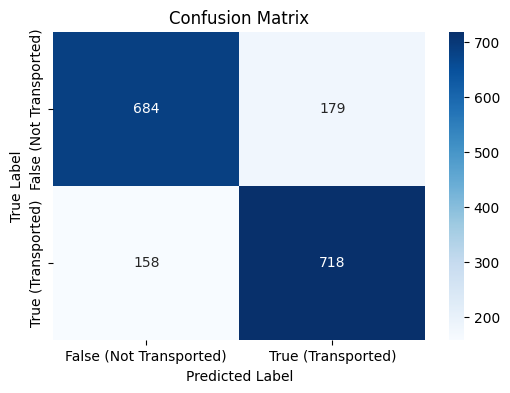

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_pred)
labels = ['False (Not Transported)', 'True (Transported)']

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

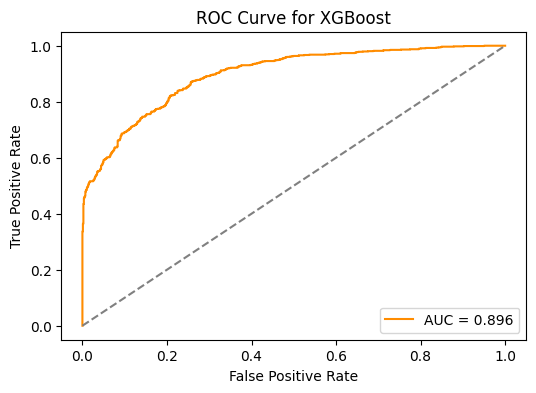

In [12]:
from sklearn.metrics import roc_curve, auc

y_scores = best_model.predict_proba(X_val)[:,1]
fpr, tpr, _ = roc_curve(y_val, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost')
plt.legend(loc='lower right')
plt.show()